In [158]:
import tensorflow as tf
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [159]:
from quantumGraphSolverFVM import QuantumGraphSolverFVM
import graph

In [160]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN

In [161]:
# Define model architecture
class PINN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 output_dim=1,
                 num_hidden_layers=2,
                 num_neurons_per_layer=10,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Inititialize num_hidden_layers many fully connected dense layers
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=tf.keras.activations.get(
                                                 activation),
                                             kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers)]
        
        # Output layer
        #self.out = tf.keras.layers.Dense(output_dim, activation=None)
        self.out = tf.keras.layers.Dense(output_dim, activation='tanh')
        
    def call(self, X):
        """Forward-pass through neural network."""
        
        #Z = self.scale(X)
        Z = X
        
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
            
        return self.out(Z)

In [162]:
# Define model architecture
class PINN_ResNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 ResNetLayers=3,
                 ResNetNeurons=12,
                 ResNetStepsize=1.0,
                 ResNetActivation='softplus',
                 **kwargs):
        
        super(PINN_ResNet, self).__init__(**kwargs)
        
        #RNact = tf.keras.activations.get(ResNetActivation)
        #RNact = my_act
        RNact = tf.keras.activations.get('tanh')

        
        self.ResNetLayers = ResNetLayers
        self.ResNetStepsize = ResNetStepsize

        self.ResNet = [tf.keras.layers.Dense(ResNetNeurons,
                                        activation=RNact) for _ in range(self.ResNetLayers)]
        self.wb = tf.keras.layers.Dense(1)
        self.A = tf.keras.layers.Dense(2, use_bias=False)
        self.c = tf.keras.layers.Dense(1, use_bias=False)
        
        #self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = 1
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Output layer
        #self.out = tf.keras.layers.Dense(1, activation='sigmoid')

        
    def call(self, input_tensor, training=False):
        """Forward-pass through neural network."""
        N = self.ResNet[0](input_tensor, training=training)
        for i in range(1, self.ResNetLayers):
            N = N + self.ResNetStepsize * self.ResNet[i](N, training=training)
        Phi = self.wb(N, training=training)
        #print(input_tensor)
        As = self.A(input_tensor, training=training)
        #print(As)
        sAs = tf.keras.layers.Dot(axes=(1))([input_tensor, As])
        #print(sAs)
        Phi += .5 * sAs
        #print(Phi.shape)
        Phi += self.c(input_tensor, training=training)
            
        return Phi
        #return self.out(Phi)

In [163]:
# Define model architecture
class PINN_CNN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 **kwargs):
        
        super().__init__(**kwargs)

        self.input_dim = lb.shape[0]
        self.lb = lb
        self.ub = ub

        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.Conv1D(5, 1, activation='sigmoid'))
        self.model.add(tf.keras.layers.AveragePooling1D(1))
        self.model.add(tf.keras.layers.Conv1D(15, 1, activation='sigmoid'))
#         self.model.add(tf.keras.layers.MaxPool1D(1))
        self.model.add(tf.keras.layers.AveragePooling1D(1))
        self.model.add(tf.keras.layers.Conv1D(5, 1, activation='sigmoid'))
        self.model.add(tf.keras.layers.AveragePooling1D(1))
        self.model.add(tf.keras.layers.Conv1D(1, 1, activation='sigmoid'))
        
    def call(self, X):
        Z = self.model(tf.reshape(X, (X.shape[0], 1, 2)))
            
        return tf.reshape(Z, (X.shape[0], 1))

In [164]:
# Define model architecture
# class PINN_ResNet_CNN(tf.keras.Model):
#     """ Set basic architecture of the PINN model."""

#     def __init__(self, lb, ub,
#                  ResNetLayers=3,
#                  ResNetNeurons=16,
#                  ResNetStepsize=1.0,
#                  ResNetActivation='softplus',
#                  **kwargs):
        
#         super(PINN_ResNet_CNN, self).__init__(**kwargs)
        
#         #RNact = tf.keras.activations.get(ResNetActivation)
#         #RNact = my_act
#         RNact = tf.keras.activations.get('sigmoid')

        
#         self.ResNetLayers = ResNetLayers
#         self.ResNetStepsize = ResNetStepsize

#         self.ResNet = tf.keras.models.Sequential()
#         self.ResNet.add(tf.keras.layers.Conv1D(5, 1, activation='sigmoid'))
#         self.ResNet.add(tf.keras.layers.AveragePooling1D(1))
#         self.ResNet.add(tf.keras.layers.Conv1D(16, 1, activation='sigmoid'))
        
        
#         self.wb = tf.keras.layers.Dense(1)
#         self.A = tf.keras.layers.Dense(2, use_bias=False)
#         self.c = tf.keras.layers.Dense(1, use_bias=False)
        
#         #self.num_hidden_layers = num_hidden_layers
#         self.input_dim = lb.shape[0]
#         self.output_dim = 1
#         self.lb = lb
#         self.ub = ub

#         # Define NN architecture
        
#         # Output layer
#         #self.out = tf.keras.layers.Dense(1, activation='sigmoid')
        
    
#     def apply(self, X):
#         Z = self.ResNet(tf.reshape(X, (X.shape[0], 1, 2)))
            
#         return tf.reshape(Z, (X.shape[0], 1))
        
#     def call(self, input_tensor, training=False):
#         """Forward-pass through neural network."""
#         N = self.apply(input_tensor)
#         for i in range(1, self.ResNetLayers):
#             N = N + self.ResNetStepsize * self.apply(N)
#         Phi = self.wb(N, training=training)
#         #print(input_tensor)
#         As = self.A(input_tensor, training=training)
#         #print(As)
#         sAs = tf.keras.layers.Dot(axes=(1))([input_tensor, As])
#         #print(sAs)
#         Phi += .5 * sAs
#         #print(Phi.shape)
#         Phi += self.c(input_tensor, training=training)
            
#         return Phi
#         #return self.out(Phi)

In [165]:
# Define model architecture
class PINN_LSTM(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 **kwargs):
        
        super().__init__(**kwargs)

        self.input_dim = lb.shape[0]
        self.lb = lb
        self.ub = ub

        self.model = Sequential()
        self.model.add(LSTM(32, activation='sigmoid', return_sequences=True))
        self.model.add(Dropout(0.2))
        self.model.add(LSTM(32, activation='sigmoid'))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(16, activation='sigmoid'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1, activation='sigmoid'))
        
    def call(self, X):
        Z = tf.reshape(X, (X.shape[0], 1, 2))
        return self.model(Z)

In [166]:
# Define model architecture
class PINN_RNN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 **kwargs):
        
        super().__init__(**kwargs)

        self.input_dim = lb.shape[0]
        self.lb = lb
        self.ub = ub

        self.model = Sequential()
        self.model.add(SimpleRNN(32, activation='sigmoid', return_sequences=True))
        self.model.add(Dropout(0.2))
        self.model.add(SimpleRNN(32, activation='sigmoid'))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(16, activation='sigmoid'))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1, activation='sigmoid'))
        
    def call(self, X):
        Z = tf.reshape(X, (X.shape[0], 1, 2))
        return self.model(Z)

In [167]:
DTYPE = 'float64'
# Lower bounds
lb = tf.constant([0, 0], dtype=DTYPE)

# Upper bounds
ub = tf.constant([10, 1], dtype=DTYPE)

pinn = PINN_ResNet(lb=lb, ub=ub)
pinn(tf.constant([[1., 1.],[1., 0.], [0., 1.]]))

<tf.Tensor: shape=(3, 1), dtype=float64, numpy=
array([[ 2.71078578],
       [-2.1377977 ],
       [ 4.26154624]])>

In [168]:
tmp=pinn.ResNet[0]
tmp.weights[0]

<tf.Variable 'pinn__res_net_18/dense_158/kernel:0' shape=(2, 12) dtype=float64, numpy=
array([[-0.3405502 ,  0.04659307,  0.63129553, -0.62074891, -0.47435669,
        -0.36344625, -0.46728975, -0.12555595, -0.27356506,  0.53451367,
        -0.51029231,  0.07936084],
       [-0.32376637,  0.64718535, -0.64601332,  0.56154122, -0.23491792,
        -0.02614318,  0.28110097, -0.25180284, -0.36796692,  0.45459621,
         0.31002079,  0.41026213]])>

In this notebook, we rely on the package [NetworkX](https://networkx.org/).
An alternative approach would be to employ [igraph](https://igraph.org/), which seems to be more lightweight.

Next, we set up the class for a graph PINN which takes either an adjacency matrix $A$ or a `MultiDiGraph` as input `inp` to define the network as well as the Dirichlet data as a list of pairs $(i, u_i)_{i=1}^{n_D}$ corresponding to $u(v_i) = u_i$.
*Notes*:
- we define our graph as a `MultiDiGraph` since graphs imported from [OpenStreetMap](https://www.openstreetmap.de/) obey this format.

In [169]:
import networkx as netx

class GraphPINN():
    
    def __init__(self, inp, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, Type = 'FNN'):
        
        if isinstance(inp, netx.classes.multidigraph.MultiGraph):
            self.G = inp
            self.A = netx.adjacency_matrix(G).toarray()
            
        elif tf.is_tensor(A) and len(A.shape)==2:
            # Store adjacency matrix
            self.A = A
            # Define networkx multigraph
            self.G = netx.MultiDiGraph(A.numpy())
            
        else:
            raise ValueError('Check input type of GraphPINN.')
        
        self.dirichletNodes = dirichletNodes
        self.dirichletAlpha = dirichletAlpha
        self.dirichletBeta = dirichletBeta
        
        self.lb = lb
        self.ub = ub
        
        # Get number of vertices
        self.n_v = self.A.shape[0]
        
        # Determine lists of edges and lengths
        self._determineEdgeList()
        
        # Determine list of vertices and incoming as well as outgoing edges
        self._determineVertexList()
        
        self.type = Type
        
        # Setup list of neural networks
        self._setupNNs()
        
        # Determine graph layout if necessary
        self.pos = netx.kamada_kawai_layout(self.G)
        
        
    def _determineEdgeList(self):
        """Determine edge matrix and weight vector.
        This could also be accomplished by a loop over `G.edges`:
            for e in G.edges:
                print(e)
        """
        
        self.E = []
        self.W = []
        
        for i in range(self.n_v):
            for j in range(i + 1, self.n_v):
                aij = self.A[i, j]
                if aij > 0:
                    #print('Connectivity between i: {} and j: {}'.format(i,j))
                    self.E.append([i, j])
                    self.W.append(aij.numpy())

        # Get number of edges
        self.ne = len(self.E)
        
    def _determineVertexList(self):
        
        self.Vin = [[] for _ in range(self.n_v)]
        self.Vout = [[] for _ in range(self.n_v)]
        
        for i, e in enumerate(self.E):
            # Unpack edge
            vin, vout = e
            self.Vin[vout].append(i)
            self.Vout[vin].append(i)            
            
        self.innerVertices = np.setdiff1d(np.arange(self.n_v), self.dirichletNodes)
            
    def _setupNNs(self):
        
        self.NNs = []
        if self.type == 'ResNet':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN_ResNet(lb=self.lb, ub=self.ub))
        elif self.type == 'FNN':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN(lb=self.lb, ub=self.ub))
        elif self.type == 'CNN':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN_CNN(lb=self.lb, ub=self.ub))
        elif self.type == 'ResNetCNN':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN_ResNet_CNN(lb=self.lb, ub=self.ub))
        elif self.type == 'LSTM':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN_LSTM(lb=self.lb, ub=self.ub))
        elif self.type == 'RNN':
            for i, e in enumerate(self.E):
                self.NNs.append(PINN_RNN(lb=self.lb, ub=self.ub))
        else:
            print('No valid type passed! FNN is used.')
            for i, e in enumerate(self.E):
                self.NNs.append(PINN(lb=self.lb, ub=self.ub))
        
    
        print('Initialized {:d} neural nets.'.format(len(self.NNs)))
    
    def plotGraph(self, **kwargs):

        netx.draw(self.G, pos=self.pos, with_labels=True, **kwargs)

### Example

First, we define a network which is determined by its
adjacency matrix $A \in \mathbb{R}_+^{n_v \times n_v}$ with $n_v$ the number of vertices.
Note that this matrix is not symmetric, as it belongs to a *directed* graph.
Here, an entry $a_{i,j} > 0$ indicates that there is an edge starting in vertex $i$ and ending in vertex $j$ with length $a_{i,j}$.

In [170]:
#DTYPE = 'float32'
DTYPE = 'float64'
adj = 5
tf.keras.backend.set_floatx(DTYPE)
time_dependent = False

# Specify adjacency matrix
if adj == 1:
    A = tf.constant([[0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0]
                ], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 1.
    xmin = 0.
    xmax = 0.1
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 7])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.8, 0.0])
    dirichletBeta = np.array([0.0, 0.5])
                              
    
    eps = 0.01
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)

    
elif adj == 2:
    A = tf.constant([[0, 1],
                 [0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    eps = .01

    dirichletNodes = np.array([0, 1])
    dirichletAlpha = np.array([0.7, 0.0])
    dirichletBeta = np.array([0.0, 0.8])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
        #return .5 +(.5*-tf.sin(x*np.pi))
    
elif adj == 3:
    A = tf.constant([[0, 1, 0],
                     [0, 0, 1],
                     [0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 0.5
    
    eps = .01

    dirichletNodes = np.array([0, 2])
    
    dirichletAlpha = np.array([0.7, 0.0])
    dirichletBeta = np.array([0.0, 0.8])
    #time_dependent = True
    #dirichletAlpha = np.array([lambda x: 0.7*x/10, lambda x: 0.0*x])
    #dirichletBeta = np.array([lambda x: 0.0, lambda x: 0.8*x/10])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
    
elif adj == 4:
    A = tf.constant([[0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 0],
                     [0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    eps = .01

    dirichletNodes = np.array([0, 2, 3])
    dirichletAlpha = np.array([0.7, 0.0, 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.0])
    
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.
    
elif adj == 0:
    A = tf.constant([[0, 0, 1,0],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1],
                 [0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 4.
    xmin = 0.
    xmax = 1.
    
    u0 = lambda x : 0
    dirichletNodes = np.array([0, 1, 3])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.8, 0.8, 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.])
                              
    
    eps = 1e-6
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
elif adj == 5:
    A = tf.constant([[0, 0, 1, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 1, 0, 0],
                     [0, 0, 0, 0, 1, 1],
                     [0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0]], dtype=tf.int16)
    # Set boundaries
    tmin = 0.
    tmax = 10.
    xmin = 0.
    xmax = 1.
    
    dirichletNodes = np.array([0, 1, 4, 5])
    #dirichletVals = np.array([1.0, 0.5])
    dirichletAlpha = np.array([0.9, 0.3, 0., 0.])
    dirichletBeta = np.array([0.0, 0.0, 0.8, 0.1])
                              
    eps = 1e-2
    def f(u):
        return u * (1-u)
    
    def df(u):
        return 1 - 2*u
    
    def pde(u, ut, ux, uxx):
        return ut - eps * uxx + df(u) * ux
    
    def flux(u, ux):
        return -eps * ux + f(u)
    
    def initial_cond(x):
        return 0.


# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)

# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

Initialized 5 neural nets.
Vin: [[], [], [0, 1], [2], [3], [4]]
Vout: [[0], [1], [2], [3, 4], [], []]


{0: array([0.61338534, 0.935451  ]),
 1: array([0.500243, 1.      ]),
 2: array([0.18949096, 0.32161507]),
 3: array([-0.18377935, -0.32492122]),
 4: array([-0.61590406, -0.93321776]),
 5: array([-0.5034359 , -0.99892709])}

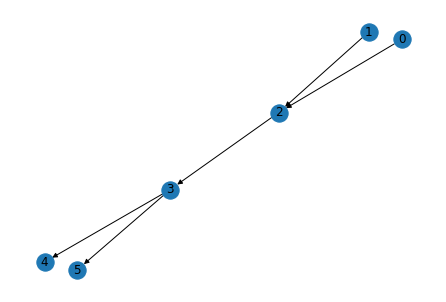

In [171]:
%matplotlib inline

gPINN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'ResNet')
gPINN.plotGraph()
print('Vin:', gPINN.Vin)
print('Vout:', gPINN.Vout)
gPINN.E
gPINN.pos

Draw collocation points uniformly or take them equidistantly distributed.

In [172]:
mode = 'deterministic'
mode = 'uniform'

N_0 = 1000
N_b = 1000
N_r = 4000

# Set random seed for reproducible results
tf.random.set_seed(0)

def drawCollocationPoints(N_0, N_b, N_r):
    X_r = tf.random.uniform((N_r,2), lb, ub, dtype=DTYPE)
    
    # Draw uniform sample points for initial boundary data
    t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
    x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
    X_0 = tf.concat([t_0, x_0], axis=1)
    
    # Boundary data
    t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
    x_l = tf.ones((N_b,1), dtype=DTYPE) * lb[1]
    X_l = tf.concat([t_b, x_l], axis=1)
    
    x_u = tf.ones((N_b,1), dtype=DTYPE) * ub[1]
    X_u = tf.concat([t_b, x_u], axis=1)
    
    X_b = tf.concat([X_l, X_u], axis=0)

    # Draw uniformly sampled collocation points
    t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
    x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
    X_r = tf.concat([t_r, x_r], axis=1)
    # X_data = tf.concat([X_0, X_b, X_r], axis=0)
    return X_r, X_0, X_l, X_u

if mode == 'deterministic':

    # Uniform distributed collocation points
    t_r = tf.linspace(lb[0], ub[0], N_0+1)
    x_r = tf.linspace(lb[1], ub[1], N_b+1)
    tt, xx = tf.meshgrid(t_r,x_r)
    X_r = tf.concat([tf.reshape(tt,(-1,1)), tf.reshape(xx,(-1,1))], axis=1)

elif mode == 'uniform':
    
    X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
    #X_data = tf.concat([X_0, X_b, X_r], axis=0)

Draw collocation points.

Text(0, 0.5, 'x')

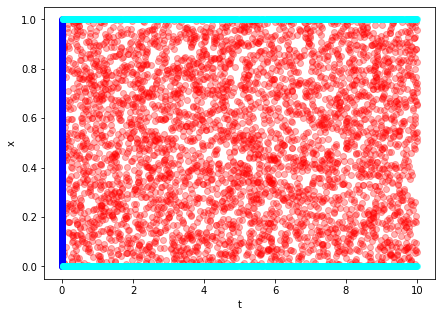

In [173]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
ax.scatter(X_r[:,0].numpy(), X_r[:,1].numpy(),color='red',alpha=0.3)
ax.scatter(X_0[:,0].numpy(), X_0[:,1].numpy(), color='blue', alpha=0.5)
ax.scatter(X_u[:,0].numpy(), X_u[:,1].numpy(), color='cyan', alpha=0.5)
ax.scatter(X_l[:,0].numpy(), X_l[:,1].numpy(), color='cyan', alpha=0.5)
ax.set_xlabel('t')
ax.set_ylabel('x')

## Set up class for time-dependent equations

We have to handle different kinds of boundary and vertex conditions:
- all inner vertices: Kirchhoff-Neumann conditon
- initial time conditions on all edges
- Dirichlet conditions on selected vertices as long as it is an inflowing node

In [174]:
from time import time

class graphPINNSolver(object):
    def __init__(self, graphPINN, Xr, X0, Xl, Xu):
        
        self.graphPINN = graphPINN
        self.ne = self.graphPINN.ne
        
        self._updateData(Xr, X0, Xl, Xu)
        
        

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        
        # Call each network once to initialize trainable variables
        self.trainable_variables = []
        for i in range(self.ne):
            self.graphPINN.NNs[i](tf.constant([[1., 1.]], dtype=DTYPE))
            self.trainable_variables.append(self.graphPINN.NNs[i].trainable_variables)
        
        # Setup auxiliary variables for vertex values to ensure continuity
        self._setupVertexVariables()
        
        for i, v in enumerate(self.graphPINN.innerVertices):
            self.trainable_variables.append([self.vertexVals[i]])
        
        self.nvar = len(self.trainable_variables)
        
    def _updateData(self, Xr, X0, Xl, Xu):
        self.Xr = Xr
        self.X0 = X0
        self.Xl = Xl
        self.Xu = Xu
        
        self.nr = Xr.shape[0]
        self.n0 = X0.shape[0]
        self.nb = Xl.shape[0]

    def _setupVertexVariables(self):
        
        self.vertexVals = []
        for _ in self.graphPINN.innerVertices:
            self.vertexVals.append(tf.Variable(tf.random.uniform(shape=(self.nb,), dtype=DTYPE), trainable=True))

    def _fvals0(self, t, x):

        # Initialize lists for values and derivatives
        u = []
        tx = tf.stack([t, x], axis=1)
        for i in range(self.ne):
            u.append(self.graphPINN.NNs[i](tx)[:,0])

        return u
    
    def _fvals1(self, t, x):
        
        # Initialize lists for values and derivatives
        u = []
        ux = []
        ut = []
        
        for i in range(self.ne):
            
            with tf.GradientTape(persistent=True) as tape:
                # Watch variables representing t and x during this GradientTape
                tape.watch(t)
                tape.watch(x)

                tx = tf.stack([t, x], axis=1)

                # Compute current values u(t,x)
                u.append(self.graphPINN.NNs[i](tx)[:, 0])
            ut.append(tape.gradient(u[i], t))
            ux.append(tape.gradient(u[i], x))
            
            del tape
                
        return u, ut, ux
    
    def _fvals2(self, t, x):
        
        # Initialize lists for values and derivatives
        u = []
        ux = []
        ut = []
        uxx = []
        
        for i in range(self.ne):
            with tf.GradientTape(persistent=True) as tape_1:
                tape_1.watch(x)
                
                with tf.GradientTape(persistent=True) as tape_2:
                    # Watch variables representing t and x during this GradientTape
                    tape_2.watch(t)
                    tape_2.watch(x)

                    tx = tf.stack([t, x], axis=1)

                    # Compute current values u(t,x)
                    u.append(self.graphPINN.NNs[i](tx)[:,0])
                    ux.append(tape_2.gradient(u[i], x))

                ut.append(tape_2.gradient(u[i], t))
                del tape_2
            
            uxx.append(tape_1.gradient(ux[i], x))
            
            del tape_1
                
        return u, ut, ux, uxx
    
    def determine_losses(self):
        # Short-hand notation of mean-squared loss
        mse = lambda x : tf.reduce_mean(tf.square(x))
        
        ###################################
        ### Residual loss for all edges ###
        ###################################
        u, ut, ux, uxx = self._fvals2(self.Xr[:,0], self.Xr[:,1])
        
        loss_res = 0
        for i in range(self.ne):
            res_e = pde(u[i], ut[i], ux[i], uxx[i])
            loss_res += mse(res_e)
        
        
        ###################################
        ### Initial conds for all edges ###
        ###################################
        
        u = self._fvals0(self.X0[:,0], self.X0[:,1])
        
        loss_init = 0
        for i in range(self.ne):
            res_e = u[i] - initial_cond(self.X0[:,1])
            loss_init += mse(res_e)
        
        ###################################
        ###   Continuity in vertices    ###
        ###################################
        
        ul, ult, ulx = self._fvals1(self.Xl[:,0], self.Xl[:,1])
        uu, uut, uux = self._fvals1(self.Xu[:,0], self.Xu[:,1])
        loss_cont = 0
        
        for i, v in enumerate(self.graphPINN.innerVertices):
            
            for j in self.graphPINN.Vin[v]:
                val = uu[j] - self.vertexVals[i]
                loss_cont += mse(val)

            for j in self.graphPINN.Vout[v]:
                val = ul[j] - self.vertexVals[i]
                loss_cont += mse(val)

        #####################################
        ### Kirchhoff-Neumann in vertices ###
        #####################################
        
        # Kirchhoff-Neumann condition in center nodes
        loss_KN = 0
        for i in self.graphPINN.innerVertices:
            
            val = 0
            print('Kirchhoff-Neumann in node ', i)
            for j in self.graphPINN.Vin[i]:
                print('incoming edge:', j)
                val += flux(uu[j], uux[j])
                
            for j in self.graphPINN.Vout[i]:
                print('outgoing edge:', j)
                val -= flux(ul[j], ulx[j])
            loss_KN += mse(val)
        
        #####################################
        ###      Inflow/Outflow conds     ###
        #####################################
            
        loss_D = 0
        for i,v in enumerate(self.graphPINN.dirichletNodes):
            
            if time_dependent:
                alpha = self.graphPINN.dirichletAlpha[i](self.Xl[:,0])
                beta = self.graphPINN.dirichletBeta[i](self.Xl[:,0])
            else:
                alpha = self.graphPINN.dirichletAlpha[i]
                beta = self.graphPINN.dirichletBeta[i]
            
            print('\nin node ', v, 'alpha ', alpha, 'beta ', beta)
            val = 0
            for j in self.graphPINN.Vin[v]:
                print('outflow: ', j)
                val += flux(uu[j], uux[j]) \
                    - beta * (uu[j])
                #loss_D += mse(val)

            for j in self.graphPINN.Vout[v]:
                print('inflow: ', j)
                val += -flux(ul[j], ulx[j]) \
                    + alpha * (1-ul[j])
                #loss_D += mse(val)
            loss_D += mse(val)
        print(loss_res)
        print(loss_init)
        print(loss_cont)
        print(loss_KN)
        print(loss_D)
        return loss_res, loss_init, loss_cont, loss_KN, loss_D
    
    def loss_fn(self):
        
        loss_res, loss_init, loss_cont, loss_KN, loss_D = self.determine_losses()
        
        loss = loss_res + loss_init + loss_cont + loss_KN + loss_D

        return loss
    
    @tf.function
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.trainable_variables)
            loss = self.loss_fn()

        g = tape.gradient(loss, self.trainable_variables)
        del tape

        return loss, g
    
    
    def solve_with_TFoptimizer(self, optimizer, N=1001):
        """This method performs a gradient descent type optimization."""
        
        self.callback_init()
        
        for i in range(N):
            loss, g = self.get_grad()

            # Perform gradient descent step
            for j in range(self.nvar):
                optimizer.apply_gradients(zip(g[j], self.trainable_variables[j]))

            self.current_loss = loss.numpy()
            self.callback()
            
    def solve_with_ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in
        Fortran which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors
            # and unknown parameters
            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    shape_list.append(v.shape)
                    weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list


        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0

            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    vs = v.shape

                    # Weight matrices
                    if len(vs) == 2:
                        sw = vs[0] * vs[1]
                        new_val = tf.reshape(
                            weight_list[idx:idx + sw], (vs[0], vs[1]))
                        idx += sw

                    # Bias vectors
                    elif len(vs) == 1:
                        new_val = weight_list[idx:idx+vs[0]]
                        idx += vs[0]

                    # Variables (in case of parameter identification setting)
                    elif len(vs) == 0:
                        new_val = weight_list[idx]
                        idx += 1

                    # Assign variables (Casting necessary since scipy requires float64 type)
                    v.assign(tf.cast(new_val, DTYPE))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from tfp.optimizer."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad()
            # Flatten gradient
            grad_flat = []
            for i in range(len(self.trainable_variables)):
                for g in grad[i]:
                    grad_flat.extend(g.numpy().flatten())

            # Store current loss for callback function
            self.current_loss = loss

            # Return value and gradient of \phi as tuple
            return loss.numpy().astype(np.float64), np.array(grad_flat, dtype=np.float64)

        self.callback_init()

        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
    
    def callback_init(self):
        self.t0 = time()
        print(' Iter            Loss    Time')
        print('-----------------------------')
    
    def callback(self, xr=None):
        if self.iter % 20 == 0:
            print('{:05d}  {:10.8e}   {:4.2f}'.format(
                self.iter, self.current_loss, time() - self.t0))
        self.hist.append(self.current_loss)
        self.iter += 1
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

# Feed Forward Neural Net

In [133]:
gPINN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'FNN')
N_0 = 1000
N_b = 1000
N_r = 4000
solver = graphPINNSolver(gPINN, X_r, X_0, X_l, X_u)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
#lr = 0.01
#optim = tf.keras.optimizers.Adam(learning_rate=lr)
#print('Start with TF optimizer\n')
#solver.solve_with_TFoptimizer(optim, N=1)

Initialized 5 neural nets.


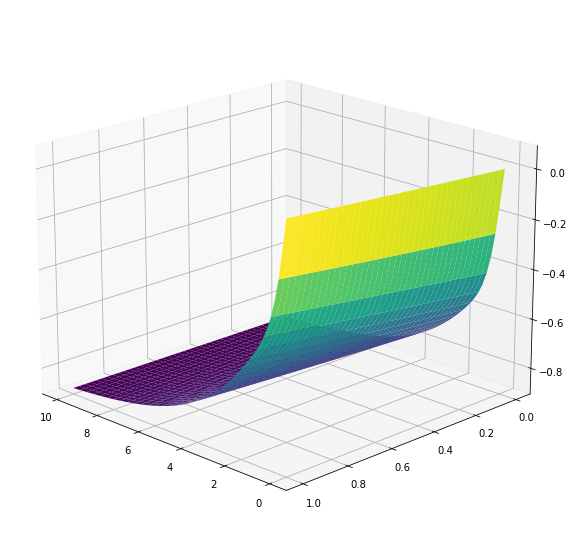

In [134]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver.graphPINN.NNs[Eidx](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)


In [135]:
# Solve with Adam optimizer
lr = 0.01
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver.solve_with_TFoptimizer(optim, N=2001)
#for i in range(20):
    # WARNING: Update of collocation points currently not supported
    # Vertex values are fixed for coordinates at boundary!
    #X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
    #solver._updateData(X_r, X_0, X_l, X_u)
    #solver.solve_with_TFoptimizer(optim, N=301)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------
Kirchhoff-Neumann in node  2
incoming edge: 0
incoming edge: 1
outgoing edge: 2
Kirchhoff-Neumann in node  3
incoming edge: 2
outgoing edge: 3
outgoing edge: 4

in node  0 alpha  0.9 beta  0.0
inflow:  0

in node  1 alpha  0.3 beta  0.0
inflow:  1

in node  4 alpha  0.0 beta  0.8
outflow:  3

in node  5 alpha  0.0 beta  0.1
outflow:  4
Tensor("add_9:0", shape=(), dtype=float64)
Tensor("add_14:0", shape=(), dtype=float64)
Tensor("add_20:0", shape=(), dtype=float64)
Tensor("add_31:0", shape=(), dtype=float64)
Tensor("add_45:0", shape=(), dtype=float64)
00000  2.65708054e+01   3.11
00020  1.65602966e+00   3.99
00040  5.01693082e-01   4.84
00060  2.82892995e-01   5.61
00080  2.32900167e-01   6.38
00100  1.94963600e-01   7.19
00120  1.77812309e-01   8.25
00140  1.69305551e-01   9.07
00160  1.64111975e-01   9.86
00180  1.60202788e-01   10.67
00200  1.56790945e-01   11.46
00220  1.53559804e-01   12.25
00240  

In [136]:
print('End with L-BFGS-B algorithm')
coarse = False

#X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*10)
#solver._updateData(X_r, X_0, X_l, X_u)
if coarse:
    ret = solver.solve_with_ScipyOptimizer(options={'maxiter': 5000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1e-12})
else:
    ret = solver.solve_with_ScipyOptimizer(options={'maxiter': 50000,
                                     'maxfun': 500000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})
print(ret.message)

End with L-BFGS-B algorithm
 Iter            Loss    Time
-----------------------------
02020  9.01332869e-02   0.60
02040  8.87105188e-02   1.21
02060  8.72793662e-02   1.87
02080  8.64189551e-02   2.45
02100  8.49074632e-02   3.09
02120  8.38264649e-02   3.69
02140  8.29273204e-02   4.28
02160  8.20445386e-02   4.86
02180  8.12139699e-02   5.47
02200  8.04050917e-02   6.06
02220  7.95181806e-02   6.65
02240  7.86006637e-02   7.29
02260  7.69652542e-02   7.98
02280  7.59532557e-02   8.70
02300  7.48938021e-02   9.47
02320  7.40691503e-02   10.16
02340  7.35008625e-02   10.90
02360  7.26825261e-02   11.65
02380  7.18420031e-02   12.42
02400  7.05992888e-02   13.14
02420  6.87245992e-02   13.88
02440  6.63945783e-02   14.60
02460  6.38123644e-02   15.29
02480  6.12984185e-02   16.04
02500  5.89777103e-02   16.74
02520  5.76162446e-02   17.42
02540  5.68245370e-02   18.11
02560  5.60612289e-02   18.80
02580  5.54239960e-02   19.54
02600  5.48447991e-02   20.26
02620  5.42981073e-02   20.

07340  1.41545069e-03   211.66
07360  1.40348781e-03   212.40
07380  1.39807896e-03   213.15
07400  1.39347529e-03   213.89
07420  1.38667486e-03   214.61
07440  1.37609154e-03   215.33
07460  1.36790260e-03   216.10
07480  1.36079366e-03   216.82
07500  1.35166081e-03   217.73
07520  1.33752277e-03   218.68
07540  1.32581387e-03   219.67
07560  1.31421602e-03   220.73
07580  1.30327794e-03   221.54
07600  1.29316768e-03   222.35
07620  1.28514210e-03   223.18
07640  1.27725596e-03   224.00
07660  1.26887667e-03   224.77
07680  1.25862110e-03   225.62
07700  1.24727723e-03   226.56
07720  1.23754783e-03   227.52
07740  1.22896957e-03   228.51
07760  1.21805799e-03   229.46
07780  1.20374460e-03   230.29
07800  1.19594190e-03   231.20
07820  1.18738351e-03   231.96
07840  1.17651898e-03   232.72
07860  1.16672513e-03   233.65
07880  1.15642744e-03   234.44
07900  1.14970002e-03   235.29
07920  1.14362613e-03   236.35
07940  1.13514886e-03   237.37
07960  1.12975487e-03   238.48
07980  1

12640  6.17683354e-04   445.15
12660  6.16854445e-04   446.03
12680  6.16168307e-04   446.86
12700  6.15273932e-04   447.79
12720  6.14098822e-04   448.65
12740  6.13307373e-04   449.54
12760  6.12683033e-04   450.42
12780  6.12053067e-04   451.23
12800  6.11364591e-04   452.04
12820  6.10830947e-04   452.86
12840  6.10245661e-04   453.65
12860  6.09634143e-04   454.49
12880  6.08925691e-04   455.32
12900  6.08387459e-04   456.16
12920  6.07770117e-04   456.95
12940  6.07125896e-04   457.82
12960  6.06433836e-04   458.62
12980  6.05702029e-04   459.50
13000  6.05193351e-04   460.42
13020  6.04674894e-04   461.28
13040  6.04175555e-04   462.23
13060  6.03582259e-04   463.01
13080  6.02797269e-04   463.77
13100  6.02029385e-04   464.57
13120  6.01087898e-04   465.33
13140  6.00298508e-04   466.18
13160  5.99761463e-04   466.98
13180  5.98743211e-04   467.79
13200  5.98037244e-04   468.63
13220  5.97162144e-04   469.37
13240  5.96466647e-04   470.14
13260  5.95738177e-04   470.93
13280  5

17940  5.13769160e-04   664.35
17960  5.13589381e-04   665.10
17980  5.13264281e-04   665.89
18000  5.12943824e-04   666.72
18020  5.12671600e-04   667.57
18040  5.12439852e-04   668.41
18060  5.12168358e-04   669.24
18080  5.11967471e-04   669.96
18100  5.11687246e-04   670.75
18120  5.11263567e-04   671.50
18140  5.10989759e-04   672.34
18160  5.10686078e-04   673.21
18180  5.10347552e-04   674.01
18200  5.09939867e-04   674.88
18220  5.09494405e-04   675.68
18240  5.09041948e-04   676.54
18260  5.08628736e-04   677.36
18280  5.08254417e-04   678.13
18300  5.07793559e-04   679.01
18320  5.07328380e-04   679.84
18340  5.07012674e-04   680.71
18360  5.06639738e-04   681.65
18380  5.06085560e-04   682.61
18400  5.05694549e-04   683.43
18420  5.05225886e-04   684.37
18440  5.04744097e-04   685.22
18460  5.04305252e-04   686.06
18480  5.03952383e-04   686.87
18500  5.03692387e-04   687.68
18520  5.03399819e-04   688.48
18540  5.03049419e-04   689.32
18560  5.02766317e-04   690.21
18580  5

23240  4.60198508e-04   887.12
23260  4.60042813e-04   888.04
23280  4.59830107e-04   889.20
23300  4.59583934e-04   890.14
23320  4.59383241e-04   891.05
23340  4.59171114e-04   892.33
23360  4.59027141e-04   893.36
23380  4.58854935e-04   894.27
23400  4.58700195e-04   895.16
23420  4.58535456e-04   896.03
23440  4.58376331e-04   896.81
23460  4.58218051e-04   897.63
23480  4.58082096e-04   898.48
23500  4.57978126e-04   899.34
23520  4.57895694e-04   900.19
23540  4.57729887e-04   901.02
23560  4.57550140e-04   901.88
23580  4.57401672e-04   902.69
23600  4.57300495e-04   903.50
23620  4.57200739e-04   904.24
23640  4.57071393e-04   905.09
23660  4.56955303e-04   905.94
23680  4.56876513e-04   906.87
23700  4.56724056e-04   907.86
23720  4.56574754e-04   908.90
23740  4.56407726e-04   909.78
23760  4.56218688e-04   910.58
23780  4.56048313e-04   911.44
23800  4.55867363e-04   912.35
23820  4.55715164e-04   913.24
23840  4.55538228e-04   914.18
23860  4.55350890e-04   914.98
23880  4

28440  4.29668375e-04   1117.49
28460  4.29582775e-04   1118.43
28480  4.29514172e-04   1119.32
28500  4.29435227e-04   1120.19
28520  4.29366280e-04   1121.06
28540  4.29259834e-04   1121.85
28560  4.29129749e-04   1122.76
28580  4.29041406e-04   1123.73
28600  4.28932367e-04   1124.66
28620  4.28850985e-04   1125.57
28640  4.28780929e-04   1126.46
28660  4.28675051e-04   1127.21
28680  4.28623261e-04   1128.03
28700  4.28483426e-04   1128.78
28720  4.28346929e-04   1129.67
28740  4.28214824e-04   1130.56
28760  4.28052795e-04   1131.69
28780  4.27902098e-04   1132.93
28800  4.27654606e-04   1134.19
28820  4.27477039e-04   1135.19
28840  4.27329407e-04   1136.22
28860  4.27212608e-04   1137.18
28880  4.27075908e-04   1138.36
28900  4.26958173e-04   1139.68
28920  4.26816222e-04   1140.77
28940  4.26736826e-04   1141.88
28960  4.26629214e-04   1142.81
28980  4.26527826e-04   1143.83
29000  4.26436059e-04   1144.85
29020  4.26344429e-04   1145.88
29040  4.26169449e-04   1146.78
29060  4

33580  4.07036972e-04   1359.58
33600  4.06982732e-04   1360.45
33620  4.06928052e-04   1361.42
33640  4.06874405e-04   1362.35
33660  4.06834400e-04   1363.22
33680  4.06785202e-04   1364.16
33700  4.06741281e-04   1365.09
33720  4.06696163e-04   1366.03
33740  4.06659003e-04   1367.03
33760  4.06608875e-04   1368.05
33780  4.06566949e-04   1369.01
33800  4.06514979e-04   1369.98
33820  4.06457766e-04   1370.95
33840  4.06397981e-04   1371.99
33860  4.06318555e-04   1373.02
33880  4.06250011e-04   1373.94
33900  4.06206209e-04   1374.87
33920  4.06157698e-04   1375.84
33940  4.06089400e-04   1376.78
33960  4.06041164e-04   1377.73
33980  4.06000300e-04   1378.59
34000  4.05943182e-04   1379.47
34020  4.05885697e-04   1380.37
34040  4.05824385e-04   1381.31
34060  4.05744304e-04   1382.21
34080  4.05675900e-04   1383.04
34100  4.05607701e-04   1384.04
34120  4.05521732e-04   1384.94
34140  4.05466922e-04   1385.89
34160  4.05409698e-04   1386.80
34180  4.05346366e-04   1387.75
34200  4

38720  3.92232324e-04   1605.20
38740  3.92177945e-04   1606.00
38760  3.92117044e-04   1606.77
38780  3.92064191e-04   1607.59
38800  3.92001038e-04   1608.39
38820  3.91942338e-04   1609.17
38840  3.91880393e-04   1610.02
38860  3.91819472e-04   1610.85
38880  3.91768161e-04   1611.80
38900  3.91697604e-04   1612.75
38920  3.91598481e-04   1613.73
38940  3.91515501e-04   1614.63
38960  3.91416568e-04   1615.50
38980  3.91350997e-04   1616.51
39000  3.91302921e-04   1617.61
39020  3.91252387e-04   1618.52
39040  3.91198412e-04   1619.55
39060  3.91123616e-04   1620.47
39080  3.91054630e-04   1621.40
39100  3.91011146e-04   1622.34
39120  3.90940614e-04   1623.22
39140  3.90870386e-04   1624.07
39160  3.90811158e-04   1624.99
39180  3.90718096e-04   1625.90
39200  3.90661872e-04   1626.82
39220  3.90592553e-04   1627.74
39240  3.90543164e-04   1628.69
39260  3.90483445e-04   1629.53
39280  3.90436629e-04   1630.39
39300  3.90382822e-04   1631.18
39320  3.90316612e-04   1632.00
39340  3

43860  3.77683277e-04   1833.34
43880  3.77631567e-04   1834.35
43900  3.77590057e-04   1835.28
43920  3.77561029e-04   1836.29
43940  3.77526576e-04   1837.22
43960  3.77479706e-04   1838.27
43980  3.77418441e-04   1839.22
44000  3.77386067e-04   1840.06
44020  3.77345612e-04   1840.90
44040  3.77308605e-04   1841.95
44060  3.77273460e-04   1843.30
44080  3.77224716e-04   1844.33
44100  3.77181147e-04   1845.30
44120  3.77151774e-04   1846.32
44140  3.77116397e-04   1847.31
44160  3.77083483e-04   1848.35
44180  3.77040924e-04   1849.25
44200  3.77003531e-04   1850.22
44220  3.76969189e-04   1851.17
44240  3.76932106e-04   1852.29
44260  3.76900846e-04   1853.47
44280  3.76866285e-04   1854.46
44300  3.76842836e-04   1855.43
44320  3.76807418e-04   1856.39
44340  3.76778979e-04   1857.33
44360  3.76754001e-04   1858.34
44380  3.76724537e-04   1859.33
44400  3.76694232e-04   1860.41
44420  3.76656893e-04   1861.46
44440  3.76631457e-04   1862.41
44460  3.76612048e-04   1863.49
44480  3

49000  3.68268633e-04   2080.51
49020  3.68232387e-04   2081.39
49040  3.68189315e-04   2082.25
49060  3.68150461e-04   2083.18
49080  3.68104533e-04   2084.06
49100  3.68067430e-04   2085.06
49120  3.68025421e-04   2085.99
49140  3.67980923e-04   2086.97
49160  3.67935414e-04   2087.93
49180  3.67909077e-04   2088.91
49200  3.67880221e-04   2089.93
49220  3.67842158e-04   2090.84
49240  3.67818781e-04   2091.87
49260  3.67785546e-04   2092.95
49280  3.67762908e-04   2093.95
49300  3.67728480e-04   2094.89
49320  3.67689596e-04   2095.81
49340  3.67645292e-04   2096.77
49360  3.67614321e-04   2097.60
49380  3.67565563e-04   2098.53
49400  3.67537240e-04   2099.38
49420  3.67487332e-04   2100.28
49440  3.67460940e-04   2101.21
49460  3.67439074e-04   2102.07
49480  3.67410284e-04   2102.90
49500  3.67379851e-04   2103.73
49520  3.67330140e-04   2104.57
49540  3.67295508e-04   2105.42
49560  3.67241650e-04   2106.29
49580  3.67192495e-04   2107.11
49600  3.67160946e-04   2108.04
49620  3

In [137]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
fig = plt.figure(1, figsize=(10, 10))
#fig.canvas.layout.width = '100%'
#fig.canvas.layout.height = '900px'
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
def plot_network(j=0):
    fig = plt.figure(1,clear=True)
    ax = fig.add_subplot(1,1,1, projection='3d')
    t0 = tf.ones_like(xspace)*tspace[j]
    pos = solver.graphPINN.pos
    for i, e in enumerate(solver.graphPINN.E):
        xy = pos[e[0]] + xspace*(pos[e[1]] - pos[e[0]]) / (ub[1]-lb[1])
        #xy = pos[e[0].numpy()] + xspace*(pos[e[1].numpy()] - pos[e[0].numpy()]) 
        #xy = V[e[0].numpy()]+xspace*(V[e[1].numpy()]-V[e[0].numpy()])
        u = solver.graphPINN.NNs[i](tf.concat([t0,xspace],axis=1))
        unum = u.numpy().flatten()
        ax.plot(xy[:,0], xy[:,1], unum)
        #ax.plot(xy[:,0], xy[:,1], unum * (1-unum))
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlim([.0,1.0])
    #ax.set_zlabel('$u_\\theta(x,y)$')
    ax.view_init(12, 135)
    return u

j_slider = widgets.IntSlider(min=0,max=Nt,step=1)
interactive_plot = interactive(plot_network, j=j_slider)
output = interactive_plot.children[-1]
#output.layout.height = '350px'
interactive_plot
#u = plot_network(4)

interactive(children=(IntSlider(value=0, description='j', max=60), Output()), _dom_classes=('widget-interact',…

<Figure size 720x720 with 0 Axes>

Surface plot of function values on a single edge.

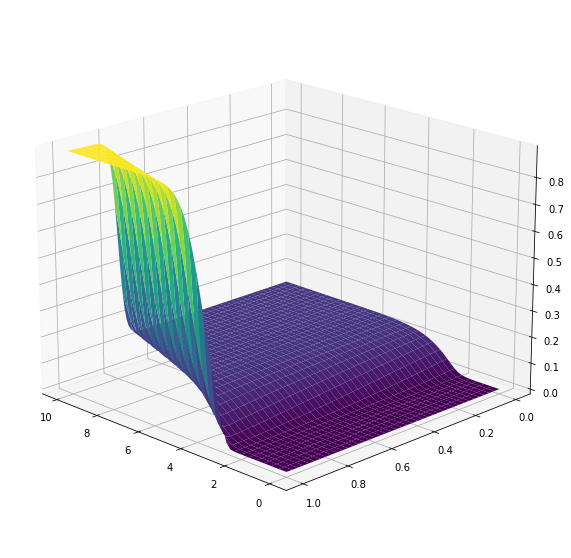

In [150]:
Eidx = 4

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)


# Residual Neural Network

In [175]:
gPINN_ResNet = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'ResNet')
N_0 = 1000
N_b = 1000
N_r = 4000
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
solver_ResNet = graphPINNSolver(gPINN_ResNet, X_r, X_0, X_l, X_u)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)

Initialized 5 neural nets.


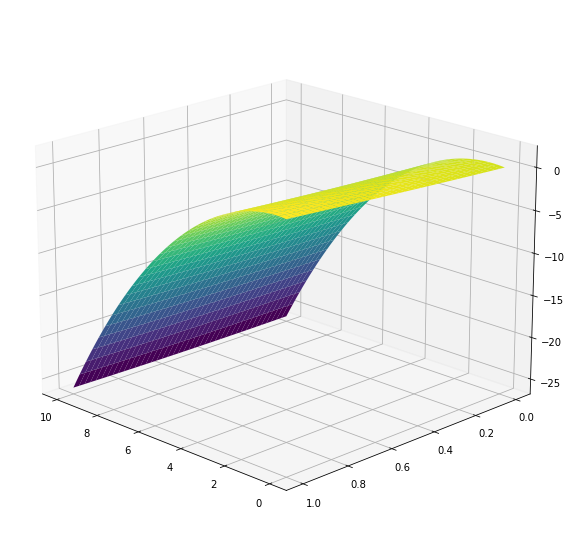

In [176]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_ResNet.graphPINN.NNs[Eidx](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

In [177]:
# Solve with Adam optimizer
lr = 0.05
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver_ResNet.solve_with_TFoptimizer(optim, N=2001)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------
Kirchhoff-Neumann in node  2
incoming edge: 0
incoming edge: 1
outgoing edge: 2
Kirchhoff-Neumann in node  3
incoming edge: 2
outgoing edge: 3
outgoing edge: 4

in node  0 alpha  0.9 beta  0.0
inflow:  0

in node  1 alpha  0.3 beta  0.0
inflow:  1

in node  4 alpha  0.0 beta  0.8
outflow:  3

in node  5 alpha  0.0 beta  0.1
outflow:  4
Tensor("add_9:0", shape=(), dtype=float64)
Tensor("add_14:0", shape=(), dtype=float64)
Tensor("add_20:0", shape=(), dtype=float64)
Tensor("add_31:0", shape=(), dtype=float64)
Tensor("add_45:0", shape=(), dtype=float64)
00000  2.43147422e+06   5.15
00020  9.02435695e+03   6.96
00040  5.74006651e+02   8.84
00060  1.48658443e+02   10.67
00080  8.27935633e+01   12.49
00100  7.04213729e+01   14.25
00120  6.34049280e+01   15.97
00140  5.83369184e+01   17.85
00160  5.40636394e+01   19.70
00180  5.03346664e+01   21.44
00200  4.70501907e+01   23.17
00220  4.41359419e+01   24.88
0

In [178]:
print('End with L-BFGS-B algorithm')
coarse = False

#X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*10)
#solver._updateData(X_r, X_0, X_l, X_u)
if coarse:
    ret = solver_ResNet.solve_with_ScipyOptimizer(options={'maxiter': 5000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1e-12})
else:
    ret = solver_ResNet.solve_with_ScipyOptimizer(options={'maxiter': 50000,
                                     'maxfun': 500000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})
print(ret.message)

End with L-BFGS-B algorithm
 Iter            Loss    Time
-----------------------------
02020  2.68107371e-01   1.68
02040  1.53716146e-01   3.32
02060  1.27733824e-01   4.90
02080  1.12612730e-01   6.40
02100  1.01985042e-01   7.91
02120  9.42584475e-02   9.47
02140  8.91878274e-02   11.45
02160  8.53610518e-02   13.39
02180  8.30469159e-02   15.12
02200  8.00153336e-02   16.78
02220  7.80398678e-02   18.60
02240  7.62135796e-02   20.26
02260  7.49496820e-02   21.98
02280  7.32063263e-02   23.57
02300  7.13043569e-02   25.15
02320  7.03340704e-02   26.80
02340  6.89941167e-02   28.37
02360  6.79067374e-02   30.01
02380  6.64943852e-02   31.73
02400  6.53802559e-02   33.52
02420  6.40939284e-02   35.14
02440  6.27065797e-02   36.86
02460  6.15978242e-02   38.45
02480  6.02881464e-02   40.02
02500  5.92389296e-02   41.57
02520  5.83488802e-02   43.07
02540  5.74139833e-02   44.56
02560  5.65320709e-02   46.16
02580  5.58028003e-02   47.78
02600  5.52503158e-02   49.44
02620  5.47895774e

07300  3.27734848e-02   425.57
07320  3.27643783e-02   427.26
07340  3.27545620e-02   428.81
07360  3.27416360e-02   430.51
07380  3.27345479e-02   432.20
07400  3.27258781e-02   433.89
07420  3.27220677e-02   435.44
07440  3.27147404e-02   437.08
07460  3.27085915e-02   438.77
07480  3.27049237e-02   440.32
07500  3.27000708e-02   441.79
07520  3.26946438e-02   443.42
07540  3.26878158e-02   444.91
07560  3.26844500e-02   446.69
07580  3.26767915e-02   448.37
07600  3.26722115e-02   450.10
07620  3.26626570e-02   451.73
07640  3.26565974e-02   453.30
07660  3.26474192e-02   454.98
07680  3.26372539e-02   456.61
07700  3.26288645e-02   458.29
07720  3.26210110e-02   459.92
07740  3.26115724e-02   461.69
07760  3.26011997e-02   463.46
07780  3.25883132e-02   465.28
07800  3.25686703e-02   466.85
07820  3.25586145e-02   468.35
07840  3.25478918e-02   470.05
07860  3.25396728e-02   471.58
07880  3.25331732e-02   473.14
07900  3.25273034e-02   474.69
07920  3.25217086e-02   476.16
07940  3

12600  3.16449220e-02   856.33
12620  3.16432857e-02   857.97
12640  3.16417219e-02   859.47
12660  3.16403942e-02   861.24
12680  3.16372105e-02   863.08
12700  3.16356009e-02   864.86
12720  3.16337252e-02   866.67
12740  3.16328102e-02   868.28
12760  3.16318643e-02   870.05
12780  3.16306369e-02   871.68
12800  3.16296296e-02   873.24
12820  3.16287572e-02   874.95
12840  3.16274529e-02   876.64
12860  3.16264717e-02   878.22
12880  3.16249977e-02   879.82
12900  3.16229333e-02   881.72
12920  3.16211291e-02   883.51
12940  3.16181167e-02   885.14
12960  3.16163222e-02   886.86
12980  3.16147715e-02   888.43
13000  3.16126882e-02   890.06
13020  3.16111048e-02   891.80
13040  3.16098903e-02   893.29
13060  3.16081092e-02   895.08
13080  3.16065340e-02   896.63
13100  3.16047169e-02   898.31
13120  3.16034878e-02   899.94
13140  3.16020893e-02   901.47
13160  3.15998910e-02   903.05
13180  3.15980281e-02   904.61
13200  3.15964484e-02   906.24
13220  3.15945777e-02   907.87
13240  3

17780  3.13222763e-02   1288.42
17800  3.13215061e-02   1290.21
17820  3.13207809e-02   1291.70
17840  3.13199788e-02   1293.49
17860  3.13187444e-02   1295.19
17880  3.13180448e-02   1296.97
17900  3.13172805e-02   1298.55
17920  3.13160859e-02   1300.26
17940  3.13151221e-02   1301.92
17960  3.13141797e-02   1303.55
17980  3.13134353e-02   1305.13
18000  3.13127159e-02   1306.80
18020  3.13119701e-02   1308.46
18040  3.13113791e-02   1310.28
18060  3.13105012e-02   1311.92
18080  3.13097837e-02   1313.74
18100  3.13093527e-02   1315.39
18120  3.13090070e-02   1316.97
18140  3.13085301e-02   1318.60
18160  3.13079875e-02   1320.26
18180  3.13075388e-02   1321.90
18200  3.13069977e-02   1323.46
18220  3.13063009e-02   1324.97
18240  3.13057716e-02   1326.68
18260  3.13053350e-02   1328.37
18280  3.13046881e-02   1330.08
18300  3.13041300e-02   1331.72
18320  3.13037725e-02   1333.44
18340  3.13032631e-02   1335.16
18360  3.13027285e-02   1336.81
18380  3.13021267e-02   1338.51
18400  3

22920  3.11769659e-02   1716.41
22940  3.11765964e-02   1718.00
22960  3.11763320e-02   1719.58
22980  3.11761456e-02   1721.18
23000  3.11758275e-02   1723.16
23020  3.11752608e-02   1724.96
23040  3.11748937e-02   1726.62
23060  3.11747395e-02   1728.20
23080  3.11744942e-02   1730.04
23100  3.11742243e-02   1731.71
23120  3.11739786e-02   1733.32
23140  3.11736925e-02   1735.02
23160  3.11733544e-02   1736.61
23180  3.11731567e-02   1738.35
23200  3.11728249e-02   1739.93
23220  3.11724942e-02   1741.61
23240  3.11721952e-02   1743.19
23260  3.11717968e-02   1744.98
23280  3.11715072e-02   1746.72
23300  3.11712500e-02   1748.24
23320  3.11710207e-02   1750.03
23340  3.11705030e-02   1751.63
23360  3.11700717e-02   1753.13
23380  3.11695321e-02   1754.83
23400  3.11690369e-02   1756.55
23420  3.11687707e-02   1758.28
23440  3.11685602e-02   1759.86
23460  3.11683746e-02   1761.70
23480  3.11679031e-02   1763.53
23500  3.11676655e-02   1765.03
23520  3.11674368e-02   1766.77
23540  3

28060  3.10717691e-02   2148.14
28080  3.10715149e-02   2149.94
28100  3.10712675e-02   2151.67
28120  3.10709844e-02   2153.44
28140  3.10708171e-02   2155.01
28160  3.10706335e-02   2156.75
28180  3.10703377e-02   2158.41
28200  3.10700458e-02   2160.01
28220  3.10697705e-02   2161.83
28240  3.10695034e-02   2163.57
28260  3.10690411e-02   2165.15
28280  3.10685353e-02   2166.75
28300  3.10679373e-02   2168.51
28320  3.10674515e-02   2170.25
28340  3.10667958e-02   2171.92
28360  3.10663189e-02   2173.65
28380  3.10658505e-02   2175.23
28400  3.10654452e-02   2176.93
28420  3.10651836e-02   2178.59
28440  3.10649578e-02   2180.11
28460  3.10647792e-02   2181.69
28480  3.10645212e-02   2183.35
28500  3.10643597e-02   2185.11
28520  3.10638425e-02   2186.85
28540  3.10634205e-02   2188.59
28560  3.10630224e-02   2190.41
28580  3.10626997e-02   2192.01
28600  3.10623174e-02   2193.78
28620  3.10619629e-02   2195.52
28640  3.10617247e-02   2197.20
28660  3.10613954e-02   2198.92
28680  3

33200  3.09838589e-02   2584.90
33220  3.09836113e-02   2586.73
33240  3.09830676e-02   2588.25
33260  3.09828376e-02   2589.99
33280  3.09825461e-02   2591.84
33300  3.09822368e-02   2593.58
33320  3.09820250e-02   2595.40
33340  3.09818035e-02   2596.92
33360  3.09815777e-02   2598.68
33380  3.09813757e-02   2600.51
33400  3.09811828e-02   2602.03
33420  3.09808348e-02   2603.73
33440  3.09805423e-02   2605.39
33460  3.09802484e-02   2607.15
33480  3.09800542e-02   2608.90
33500  3.09797268e-02   2610.59
33520  3.09794236e-02   2612.35
33540  3.09790956e-02   2614.17
33560  3.09788892e-02   2615.77
33580  3.09786677e-02   2617.46
33600  3.09782058e-02   2619.08
33620  3.09779123e-02   2620.75
33640  3.09775111e-02   2622.37
33660  3.09772389e-02   2624.05
33680  3.09768677e-02   2625.90
33700  3.09764597e-02   2627.65
33720  3.09761095e-02   2629.41
33740  3.09756443e-02   2631.18
33760  3.09753937e-02   2633.01
33780  3.09751170e-02   2634.77
33800  3.09748244e-02   2636.45
33820  3

38340  3.08636311e-02   3024.01
38360  3.08630940e-02   3025.87
38380  3.08623977e-02   3027.58
38400  3.08617283e-02   3029.37
38420  3.08611723e-02   3031.09
38440  3.08607490e-02   3032.79
38460  3.08603695e-02   3034.42
38480  3.08600031e-02   3035.99
38500  3.08596474e-02   3037.63
38520  3.08593322e-02   3039.34
38540  3.08587900e-02   3040.96
38560  3.08584646e-02   3042.78
38580  3.08580735e-02   3044.55
38600  3.08577985e-02   3046.30
38620  3.08574326e-02   3047.88
38640  3.08569500e-02   3049.67
38660  3.08566383e-02   3051.38
38680  3.08562297e-02   3053.15
38700  3.08558200e-02   3054.80
38720  3.08554358e-02   3056.34
38740  3.08551231e-02   3058.08
38760  3.08548525e-02   3059.72
38780  3.08545341e-02   3061.45
38800  3.08541740e-02   3063.16
38820  3.08537911e-02   3064.77
38840  3.08531131e-02   3066.39
38860  3.08526958e-02   3068.08
38880  3.08519792e-02   3069.87
38900  3.08512138e-02   3071.81
38920  3.08507465e-02   3073.74
38940  3.08503494e-02   3075.42
38960  3

43480  3.07691882e-02   3467.27
43500  3.07684379e-02   3469.01
43520  3.07678196e-02   3470.88
43540  3.07673025e-02   3472.82
43560  3.07667739e-02   3474.84
43580  3.07659449e-02   3476.60
43600  3.07654086e-02   3478.34
43620  3.07649598e-02   3480.24
43640  3.07642616e-02   3482.06
43660  3.07636215e-02   3483.89
43680  3.07626827e-02   3485.76
43700  3.07620798e-02   3487.56
43720  3.07614102e-02   3489.38
43740  3.07605597e-02   3491.15
43760  3.07600184e-02   3492.80
43780  3.07596784e-02   3494.43
43800  3.07593029e-02   3496.20
43820  3.07588699e-02   3497.83
43840  3.07584113e-02   3499.46
43860  3.07579255e-02   3501.09
43880  3.07573403e-02   3502.88
43900  3.07567701e-02   3504.54
43920  3.07561333e-02   3506.47
43940  3.07555236e-02   3508.18
43960  3.07547904e-02   3509.95
43980  3.07542182e-02   3511.70
44000  3.07535145e-02   3513.41
44020  3.07527843e-02   3515.17
44040  3.07522939e-02   3516.89
44060  3.07517976e-02   3518.52
44080  3.07512982e-02   3520.14
44100  3

48620  3.05936208e-02   3913.34
48640  3.05931615e-02   3915.03
48660  3.05926605e-02   3916.76
48680  3.05920548e-02   3918.61
48700  3.05911157e-02   3920.26
48720  3.05904182e-02   3922.37
48740  3.05896943e-02   3924.02
48760  3.05891448e-02   3925.85
48780  3.05884697e-02   3927.61
48800  3.05877408e-02   3929.36
48820  3.05871397e-02   3931.12
48840  3.05862521e-02   3932.78
48860  3.05854588e-02   3934.52
48880  3.05847834e-02   3936.22
48900  3.05843255e-02   3938.16
48920  3.05837656e-02   3939.98
48940  3.05831656e-02   3941.89
48960  3.05826900e-02   3943.62
48980  3.05822085e-02   3945.37
49000  3.05815481e-02   3947.08
49020  3.05810560e-02   3949.05
49040  3.05807415e-02   3950.78
49060  3.05802875e-02   3952.62
49080  3.05796814e-02   3954.72
49100  3.05789332e-02   3956.39
49120  3.05783821e-02   3958.21
49140  3.05778809e-02   3959.94
49160  3.05773815e-02   3961.54
49180  3.05770062e-02   3963.37
49200  3.05765354e-02   3965.24
49220  3.05758767e-02   3967.07
49240  3

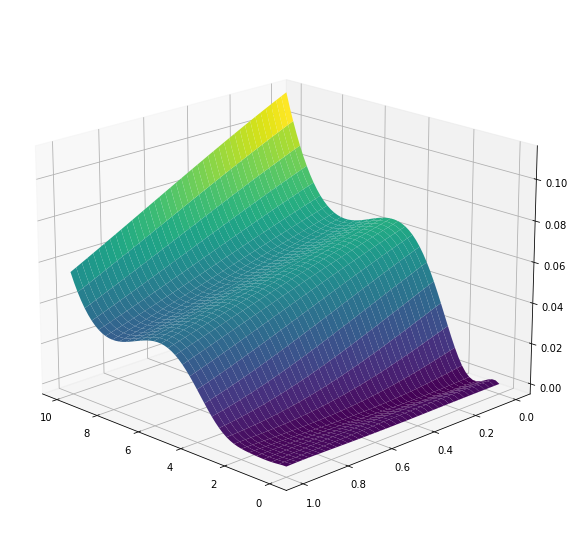

In [189]:
Eidx = 4

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_ResNet.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

# CNN

In [30]:
gPINN_CNN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'CNN')
N_0 = 1000
N_b = 1000
N_r = 4000
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
solver_CNN = graphPINNSolver(gPINN_CNN, X_r, X_0, X_l, X_u)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)

Initialized 1 neural nets.


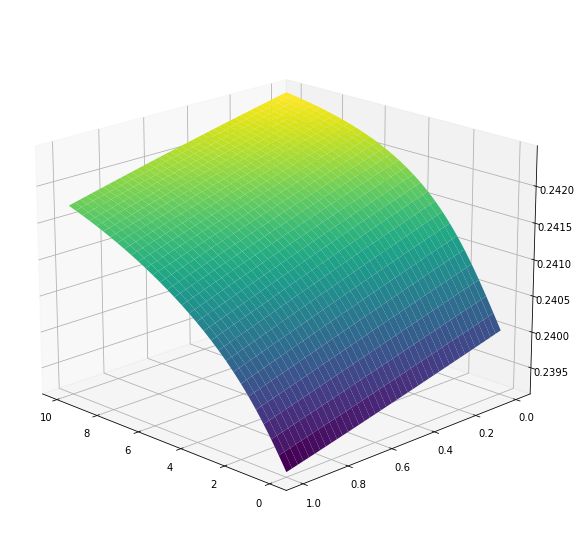

In [31]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_CNN.graphPINN.NNs[Eidx](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

In [32]:
lr = 0.05
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver_CNN.solve_with_TFoptimizer(optim, N=2001)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------

in node  0 alpha  0.7 beta  0.0
inflow:  0

in node  1 alpha  0.0 beta  0.8
outflow:  0
Tensor("add_1:0", shape=(), dtype=float64)
Tensor("add_2:0", shape=(), dtype=float64)
0
0
Tensor("add_9:0", shape=(), dtype=float64)
00000  1.78187421e-01   1.54
00020  6.53391615e-02   1.87
00040  3.27845200e-02   2.26
00060  1.21505855e-02   2.66
00080  1.01261851e-02   3.09
00100  9.49817878e-03   3.56
00120  9.14398441e-03   4.02
00140  8.86842085e-03   4.44
00160  8.62211128e-03   4.89
00180  8.38523395e-03   5.29
00200  8.14977425e-03   5.68
00220  7.91201352e-03   6.09
00240  7.67127919e-03   6.49
00260  8.36649570e-03   6.89
00280  7.38951374e-03   7.33
00300  7.04076461e-03   7.72
00320  6.82457792e-03   8.11
00340  6.62289085e-03   8.49
00360  6.44348131e-03   8.84
00380  6.28474201e-03   9.22
00400  6.14370831e-03   9.61
00420  6.01580436e-03   10.01
00440  5.92219704e-03   10.39
00460  5.80478260e-03   

In [33]:
# print('End with L-BFGS-B algorithm')
# coarse = False

# #X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*10)
# #solver._updateData(X_r, X_0, X_l, X_u)
# if coarse:
#     ret = solver_CNN.solve_with_ScipyOptimizer(options={'maxiter': 10000,
#                                      'maxfun': 50000,
#                                      'maxcor': 50,
#                                      'maxls': 50,
#                                      'ftol': 1e-12})
# else:
#     ret = solver_CNN.solve_with_ScipyOptimizer(options={'maxiter': 10000,
#                                      'maxfun': 50000,
#                                      'maxcor': 50,
#                                      'maxls': 50,
#                                      'ftol': 1.0*np.finfo(float).eps})
# print(ret.message)

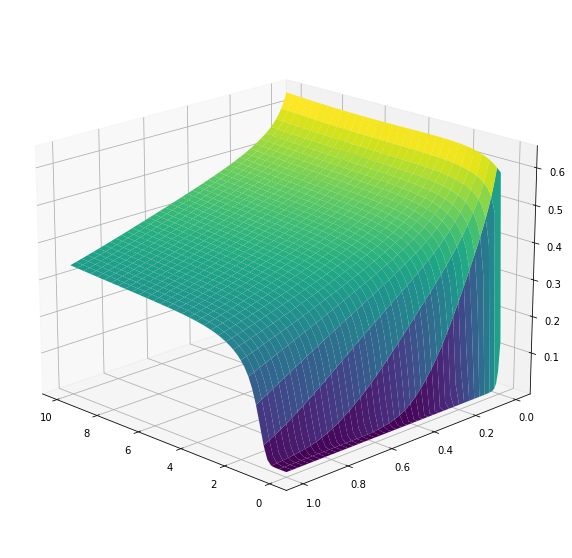

In [34]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_CNN.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

# ResNet CNN

In [35]:
# gPINN_ResNet_CNN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'ResNetCNN')
# N_0 = 1000
# N_b = 1000
# N_r = 4000
# X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
# solver_ResNet_CNN = graphPINNSolver(gPINN_ResNet_CNN, X_r, X_0, X_l, X_u)
# X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)

# Recurrent Neural Network

In [36]:
gPINN_RNN = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'RNN')
N_0 = 1000
N_b = 1000
N_r = 4000
solver_RNN = graphPINNSolver(gPINN_RNN, X_r, X_0, X_l, X_u)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
#lr = 0.01
#optim = tf.keras.optimizers.Adam(learning_rate=lr)
#print('Start with TF optimizer\n')
#solver.solve_with_TFoptimizer(optim, N=1)

Initialized 1 neural nets.


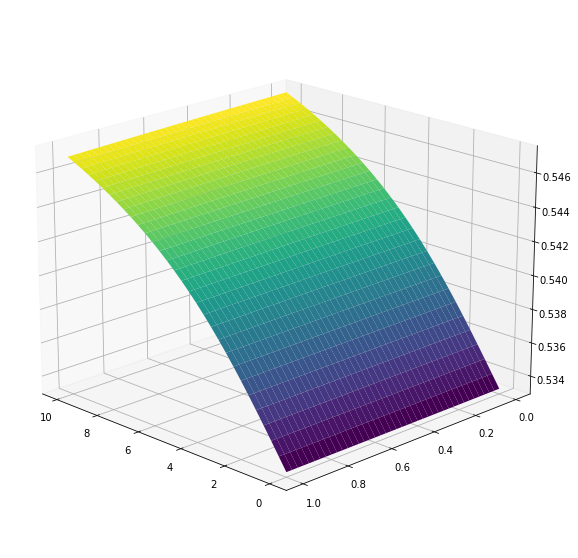

In [37]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_RNN.graphPINN.NNs[Eidx](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

In [38]:
lr = 0.05
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver_RNN.solve_with_TFoptimizer(optim, N=2001)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------

in node  0 alpha  0.7 beta  0.0
inflow:  0

in node  1 alpha  0.0 beta  0.8
outflow:  0
Tensor("add_1:0", shape=(), dtype=float64)
Tensor("add_2:0", shape=(), dtype=float64)
0
0
Tensor("add_9:0", shape=(), dtype=float64)
00000  3.23825395e-01   13.65
00020  1.17621659e-01   15.73
00040  4.06235028e-02   18.06
00060  2.14058929e-02   20.33
00080  9.48131297e-03   22.46
00100  7.99806181e-03   24.77
00120  7.07452486e-03   26.98
00140  6.31560924e-03   29.07
00160  5.90496502e-03   31.14
00180  5.22266134e-03   33.26
00200  4.77734193e-03   35.31
00220  4.37600793e-03   37.43
00240  4.17000253e-03   39.55
00260  3.87892782e-03   41.75
00280  3.41660211e-03   43.87
00300  3.32669992e-03   45.92
00320  2.93456528e-03   47.96
00340  2.94841779e-03   49.96
00360  2.66753099e-03   52.02
00380  2.63987236e-03   54.06
00400  2.55235426e-03   56.13
00420  2.50026886e-03   58.28
00440  2.56745004e-03   60.35
004

In [39]:
print('End with L-BFGS-B algorithm')
coarse = False

#X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*10)
#solver._updateData(X_r, X_0, X_l, X_u)
if coarse:
    ret = solver_RNN.solve_with_ScipyOptimizer(options={'maxiter': 10000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1e-12})
else:
    ret = solver_RNN.solve_with_ScipyOptimizer(options={'maxiter': 10000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})
print(ret.message)

End with L-BFGS-B algorithm
 Iter            Loss    Time
-----------------------------
02020  1.95233301e-03   2.09
02040  1.94257690e-03   4.14
02060  1.93180723e-03   6.45
02080  1.92652570e-03   8.55
02100  1.92247441e-03   10.45
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


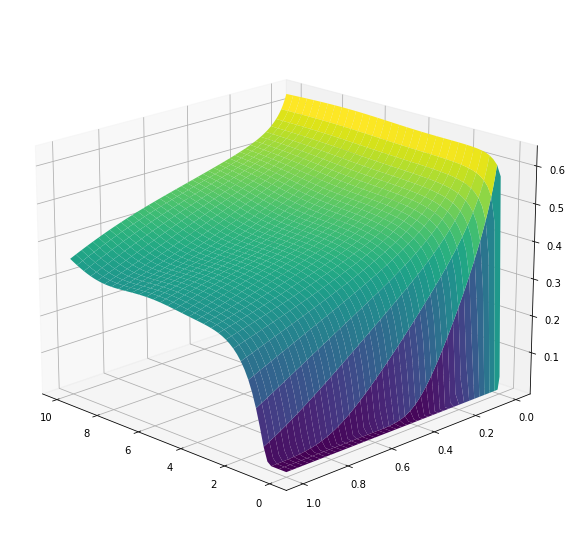

In [40]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_RNN.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

# LSTM

In [41]:
gPINN_LSTM = GraphPINN(A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub, 'LSTM')
N_0 = 1000
N_b = 1000
N_r = 4000
solver_LSTM = graphPINNSolver(gPINN_LSTM, X_r, X_0, X_l, X_u)
X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r)
#lr = 0.01
#optim = tf.keras.optimizers.Adam(learning_rate=lr)
#print('Start with TF optimizer\n')b
#solver.solve_with_TFoptimizer(optim, N=1)

Initialized 1 neural nets.


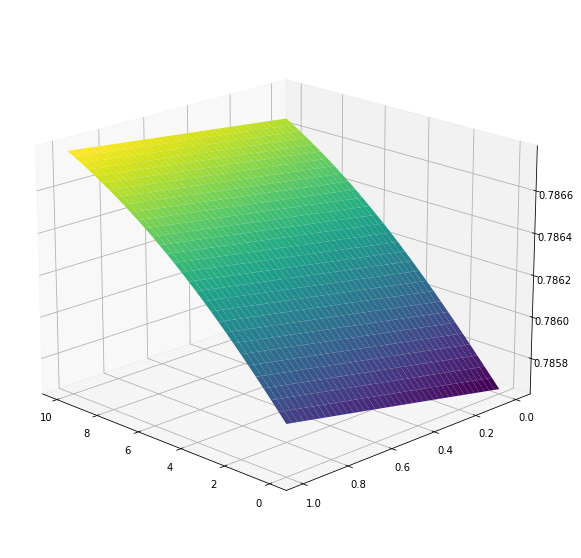

In [42]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_LSTM.graphPINN.NNs[Eidx](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

In [43]:
lr = 0.05
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver_LSTM.solve_with_TFoptimizer(optim, N=2001)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------

in node  0 alpha  0.7 beta  0.0
inflow:  0

in node  1 alpha  0.0 beta  0.8
outflow:  0
Tensor("add_1:0", shape=(), dtype=float64)
Tensor("add_2:0", shape=(), dtype=float64)
0
0
Tensor("add_9:0", shape=(), dtype=float64)
00000  8.30418971e-01   29.82
00020  1.72382393e-01   37.48
00040  7.27232937e-02   46.64
00060  3.68876299e-02   55.29
00080  2.93599909e-02   63.76
00100  9.85633468e-03   72.35
00120  8.18888647e-03   80.90
00140  7.10767499e-03   89.41
00160  6.26929086e-03   97.70
00180  5.48372494e-03   105.95
00200  4.71913595e-03   114.00
00220  4.35908906e-03   121.97
00240  3.85163101e-03   129.98
00260  3.42834374e-03   137.98
00280  3.12389058e-03   145.91
00300  2.93803475e-03   153.84
00320  2.79640714e-03   161.56
00340  2.68717581e-03   170.08
00360  2.60005377e-03   177.77
00380  2.52928222e-03   185.39
00400  2.47055621e-03   192.98
00420  2.42067116e-03   200.49
00440  2.37749244e-0

KeyboardInterrupt: 

In [ ]:
print('End with L-BFGS-B algorithm')
coarse = False

#X_r, X_0, X_l, X_u = drawCollocationPoints(N_0, N_b, N_r*10)
#solver._updateData(X_r, X_0, X_l, X_u)
if coarse:
    ret = solver_LSTM.solve_with_ScipyOptimizer(options={'maxiter': 10000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1e-12})
else:
    ret = solver_LSTM.solve_with_ScipyOptimizer(options={'maxiter': 10000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})
print(ret.message)

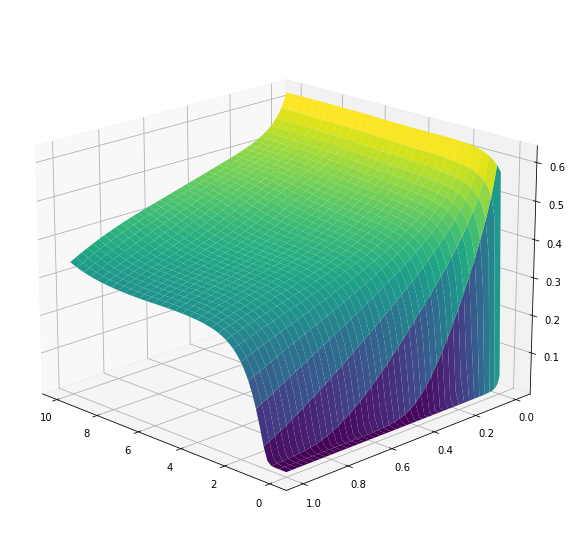

In [44]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_LSTM.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

# FVM

In [190]:
xth_frame = 5
# Time discretization of FVM
nt = N_b * xth_frame
# Spatial discretization of FVM
nx = N_0 + 1

graph_FVM = graph.Example2()
graph_FVM.buildGraph()

fvm_solver = QuantumGraphSolverFVM(graph_FVM)
u_fvm = fvm_solver.solve(nx=nx, nt=nt)

In [191]:
nt

5000

In [192]:
nx

1001

In [193]:
np.shape(u_fvm)

(5001, 5000)

In [194]:
u_fvm[0, :]

array([0.        , 0.28809592, 0.3360281 , ..., 0.85937852, 0.85937886,
       0.85937921])

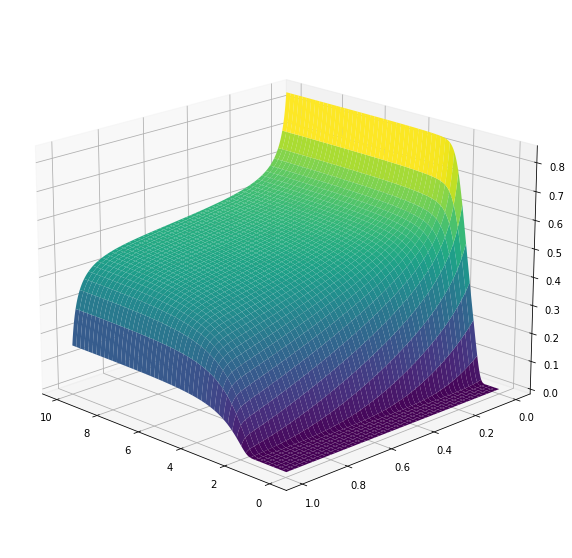

In [195]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

t_fvm = [i * 1./500. for i in range(np.shape(u_fvm)[1])]
x_fvm = [i / nx for i in range(1000)]

T, X = tf.meshgrid(t_fvm[:], x_fvm[:999])
ax.plot_surface(T, X, u_fvm[1998:2997, :], cmap='viridis')
ax.view_init(19, 135)

# Comparsion

In [196]:
T, X = tf.meshgrid(t_fvm, x_fvm[:999])
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U1 = solver_ResNet.graphPINN.NNs[0](TX)
U1 = tf.reshape(U1, T.shape)
U2 = solver_ResNet.graphPINN.NNs[1](TX)
U2 = tf.reshape(U2, T.shape)
U3 = solver_ResNet.graphPINN.NNs[2](TX)
U3 = tf.reshape(U3, T.shape)
U4 = solver_ResNet.graphPINN.NNs[3](TX)
U4 = tf.reshape(U4, T.shape)
U5 = solver_ResNet.graphPINN.NNs[4](TX)
U5 = tf.reshape(U5, T.shape)

In [197]:
print(tf.linalg.norm(U5 - u_fvm[3996:4995, :]))

tf.Tensor(502.4273477363924, shape=(), dtype=float64)


In [198]:
U_FNN = tf.concat([U1, U2, U3, U4, U5], axis = 0)
print(tf.linalg.norm(U_FNN - u_fvm[:4995, :]))
print(np.max(tf.abs(U_FNN - u_fvm[:4995, :])))

tf.Tensor(1530.2266754494092, shape=(), dtype=float64)
0.8705551259854093


In [196]:
T, X = tf.meshgrid(t_fvm, x_fvm)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)

    
# T2, X2 = tf.meshgrid(t_fvm, x_fvm[1000:1999])
# TX2 =tf.stack([tf.reshape(T2,-1), tf.reshape(X2,-1)],axis=1)
# tf.concat([solver.graphPINN.NNs[0](TX), solver.graphPINN.NNs[1](TX2)], axis = 1)
tf.concat([solver.graphPINN.NNs[0](TX), solver.graphPINN.NNs[1](TX)], axis = 1)
solver.graphPINN.NNs[0](TX)
U_FNN = tf.reshape(U_FNN, T.shape)

<tf.Tensor: shape=(4995000, 1), dtype=float64, numpy=
array([[0.02146962],
       [0.09517329],
       [0.16052252],
       ...,
       [0.85060858],
       [0.85060858],
       [0.85060859]])>

In [197]:
Eidx = 0
T, X = tf.meshgrid(t_fvm, x_fvm[:999])
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U_FNN = solver.graphPINN.NNs[Eidx](TX) 
U_FNN = tf.reshape(U_FNN, T.shape)
# U_ResNet = solver_ResNet.graphPINN.NNs[Eidx](TX) 
# U_ResNet = tf.reshape(U_ResNet, T.shape)
# U_CNN = solver_CNN.graphPINN.NNs[Eidx](TX) 
# U_CNN = tf.reshape(U_CNN, T.shape)
# U_RNN = solver_RNN.graphPINN.NNs[Eidx](TX) 
# U_RNN = tf.reshape(U_RNN, T.shape)

In [198]:
print(u_fvm.shape)
# print(U_ResNet.shape)
print(U_FNN.shape)
# print(U_CNN.shape)
# print(U_RNN.shape)

(5001, 5000)
(999, 5000)


In [49]:
print(tf.linalg.norm(U_FNN - u_fvm[:999, :]))
print(tf.linalg.norm(U_ResNet - u_fvm[:999, :]))
print(tf.linalg.norm(U_CNN - u_fvm[:999, :]))
print(tf.linalg.norm(U_RNN - u_fvm[:999, :]))

tf.Tensor(5.91513142408256, shape=(), dtype=float64)
tf.Tensor(8.053447005280013, shape=(), dtype=float64)
tf.Tensor(102.71403129536804, shape=(), dtype=float64)
tf.Tensor(103.22477874605994, shape=(), dtype=float64)


In [50]:
print(np.max(tf.abs(U_FNN - u_fvm[:999, :])))
print(np.max(tf.abs(U_ResNet - u_fvm[:999, :])))
print(np.max(tf.abs(U_CNN - u_fvm[:999, :])))
print(np.max(tf.abs(U_RNN - u_fvm[:999, :])))

0.2684886048506244
0.1469210458800389
0.13135781162785637
0.15340351676464925


In [ ]:
input_shape = (100, 1, 2)
x = tf.random.normal(input_shape)
y = tf.keras.layers.Conv1D(23, 1, activation='sigmoid')(x)
print(y.shape)

# Stuff

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

x_train = tf.random.normal((100,2))

model = Sequential()


model.add(LSTM(128, activation='sigmoid', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='sigmoid'))
model.add(Dropout(0.1))

model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
x_train = tf.random.normal((100, 1, 2))
model(x_train)

In [ ]:
# inputs = tf.random.normal([32, 10, 8])
inputs = tf.random.normal((100,2))
inputs = tf.reshape(inputs, (100, 1, 2))


lstm = tf.keras.layers.LSTM(128)
output = lstm(inputs)
print(output.shape)

lstm = tf.keras.layers.LSTM(4, return_sequences=True, return_state=True)
whole_seq_output, final_memory_state, final_carry_state = lstm(inputs)
print(whole_seq_output.shape)

print(final_memory_state.shape)

print(final_carry_state.shape)


In [ ]:
model = Sequential()
model.add(Dense(units=24, activation="sigmoid"))
model.add(Dense(units=22, activation="sigmoid"))
model.add(Dense(units=32, activation="sigmoid"))
model.add(Dense(units=2, activation="sigmoid"))
model.add(Dense(units=2, activation="sigmoid"))
model.add(Dense(units=2))